In [6]:
%cd ~/desktop/RNA/casp16
casp_id = "M1282"
pdb_dir=f"./datasets/casp16/{casp_id}/zdock/pdb"

/Users/sumishunsuke/Desktop/RNA/casp16


# energy 

In [7]:
!ls {pdb_dir}/*pdb | wc -l

!python ./scripts/eval_scores.py --pdb_dir {pdb_dir} --out_dir {pdb_dir} --cpu 8

    1000
['zdock.S_000485-top1.pdb', 'zdock.S_000815-top1.pdb', 'zdock.S_000484-top1.pdb', 'zdock.S_000814-top1.pdb']
Traceback (most recent call last):
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./scripts/eval_scores.py", line 83, in <module>
    main()
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./scripts/eval_scores.py", line 66, in main
    res_rnabriq = RNA_BRiQ.RNA_BRiQ_eval_batch(args.pdb_dir, args.out_dir, args.cpu)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./src/score/RNA_BRiQ.py", line 67, in RNA_BRiQ_eval_batch
    energy = float(lines[-1].strip().replace("Energy: ", ""))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'check ribose:'


In [8]:
!say "evaluation done"

In [12]:
all_pdb_ids = !ls {pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f2 | cut -d- -f1
all_pdb_ids[:3]

['S_000001', 'S_000002', 'S_000003']

In [20]:
# re-proc

all_pdb_ids = !ls {pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f2 | cut -d- -f1
print(len(all_pdb_ids))

energies = {}
unprocessed = []
for pdb_id in all_pdb_ids:
    f = f"{pdb_dir}/zdock.{pdb_id}-top1.briq.out"
    try:
        with open(f) as fh: lines = fh.readlines()
        energies[f] = float(lines[-1].strip().replace("Energy: ", ""))
    except:
        unprocessed.append(pdb_id)

print(len(energies), len(unprocessed))

1000
1000 0


In [21]:
# import sys
# sys.path.append("./")
# from src.score import RNA_BRiQ
# from multiprocessing import Pool

# with Pool(3) as pool:
#     results = pool.map(
#         RNA_BRiQ.process_pdb_file_eval,
#         [f"{pdb_dir}/zdock.{pdb_id}-top1.pdb" for pdb_id in unprocessed]
#         )

# energy書き出し

In [24]:
out_files[:1]

['./datasets/casp16/M1282/zdock/pdb/zdock.S_000001-top1.briq.out']

In [31]:
out_files = !ls {pdb_dir}/*briq.out

pdb_energy = {}
for out in out_files:
    with open(out) as fh: 
        lines = fh.readlines()
    energies = float(lines[-1].strip().replace("Energy: ", ""))
    basename = out.split("/")[-1].replace("-top1.briq.out", "").replace("zdock.", "")
    pdb_energy[basename] = energies


# pdb_energy["S_000001"]

import pandas as pd
df_briq = pd.DataFrame(pdb_energy.items(), columns=["pdb", "BRiQscore"])
df_briq.head(3)

,pdb,BRiQscore
0,S_000001,-12.0093
1,S_000002,-38.6090
2,S_000003,-88.8257


In [43]:
df_zdock = pd.read_csv(f"{pdb_dir}/ZDOCKscore.csv", header=None)
df_zdock.columns = ["pdb", "ZDOCKscore"]
print(df_zdock.head(3))

                       pdb  ZDOCKscore
0  zdock.S_000001-top1.pdb    2621.857
1  zdock.S_000002-top1.pdb    2662.368
2  zdock.S_000003-top1.pdb    2473.150


In [46]:
import pandas as pd 
df_zdock = pd.read_csv(f"{pdb_dir}/ZDOCKscore.csv", header=None)
df_zdock.columns = ["pdb", "ZDOCKscore"]
df_zdock["pdb"] = [f.split("/")[-1].replace("zdock.", "").replace("-top1.pdb", "") for f in df_zdock["pdb"]]
df = pd.merge(df_briq, df_zdock, on="pdb")
df.shape

df.to_csv(f"{pdb_dir}/{casp_id}_scores.csv", index=False)

(442, 3)


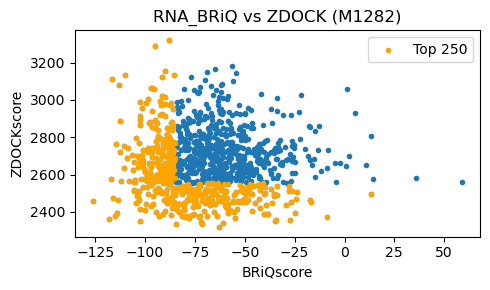

In [48]:
import pandas as pd
import os
import matplotlib.pyplot as plt

df_scores = pd.read_csv(f"{pdb_dir}/{casp_id}_scores.csv")


n_take = 250
df_briq_top = df_scores.sort_values("BRiQscore", ascending=True).head(n_take)
df_farfar_top = df_scores.sort_values("ZDOCKscore", ascending=True).head(n_take)
df_both_top = pd.concat([df_briq_top, df_farfar_top]).drop_duplicates()


plt.figure(figsize=(5,3))
plt.scatter(df_scores["BRiQscore"], df_scores["ZDOCKscore"], marker=".")
plt.scatter(df_both_top["BRiQscore"], df_both_top["ZDOCKscore"], marker=".", color="orange", label=f"Top {n_take}")
plt.legend()
plt.xlabel("BRiQscore")
plt.ylabel("ZDOCKscore")
plt.title(f"RNA_BRiQ vs ZDOCK ({casp_id})")

print(df_both_top.shape)
plt.tight_layout()
# plt.savefig(f"{pdb_dir}/{casp_id}_scores.pdf")

# 距離計算
両方のtop250の集団からに絞った.  

In [ ]:
pdb_dir

'./datasets/casp16/R1286/pdb'

In [18]:
# for i,row in df_both_top.iterrows():
#     pdb = row["pdb"]
#     !cp {pdb_dir}/{pdb}.pdb datasets/casp16/R1286/top_pdbs/

In [13]:
%cd ~/desktop/RNA/casp16
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, Superimposer
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

/Users/sumishunsuke/Desktop/RNA/casp16


/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [20]:
top_pdb_dir = "./datasets/casp16/R1286/top_pdbs"
!ls {top_pdb_dir} | wc -l

     397


In [21]:
!time python scripts/calc_rmsd.py --pdb_dir {top_pdb_dir} --cpu 8

['S_000005.pdb', 'S_000010.pdb', 'S_000011.pdb', 'S_000014.pdb', 'S_000015.pdb']
Number of pdb files: 397
Calculating RMSD matrix 397x397 using 8 cpus
Calculating RMSD for 0th pdb file
Calculating RMSD for 40th pdb file
Calculating RMSD for 20th pdb file
Calculating RMSD for 50th pdb file
Calculating RMSD for 10th pdb file
Calculating RMSD for 30th pdb file
Calculating RMSD for 100th pdb file
Calculating RMSD for 70th pdb file
Calculating RMSD for 110th pdb file
Calculating RMSD for 80th pdb file
Calculating RMSD for 90th pdb file
Calculating RMSD for 60th pdb file
Calculating RMSD for 120th pdb file
Calculating RMSD for 190th pdb file
Calculating RMSD for 180th pdb file
Calculating RMSD for 130th pdb file
Calculating RMSD for 170th pdb file
Calculating RMSD for 140th pdb file
Calculating RMSD for 160th pdb file
Calculating RMSD for 150th pdb file
Calculating RMSD for 240th pdb file
Calculating RMSD for 200th pdb file
Calculating RMSD for 300th pdb file
Calculating RMSD for 260th pdb f

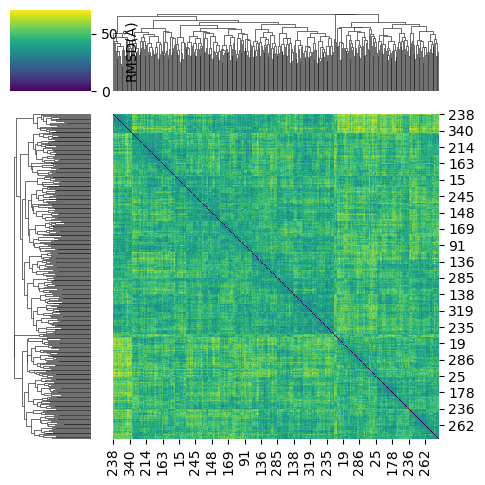

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

rmsd = np.load(f"{top_pdb_dir}/rmsd_matrix_sorted_id.npy")
g = sns.clustermap(rmsd, cmap="viridis", figsize=(5,5), cbar_kws={'label': 'RMSD(Å)', 'aspect': 20})
plt.tight_layout()
plt.savefig(f"{top_pdb_dir}/rmsd_clustermap.png", dpi = 300)

In [24]:
all_pdb_ids = !ls {top_pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f1
print(len(all_pdb_ids))
print(all_pdb_ids[:3])

397
['S_000005', 'S_000010', 'S_000011']


In [25]:
df_rmsd = pd.DataFrame(rmsd, columns=all_pdb_ids, index=all_pdb_ids)
df_rmsd.to_csv(f"{top_pdb_dir}/rmsd_matrix_sorted_id.csv")

# clustering

In [26]:
import numpy as np
from sklearn.manifold import MDS

rmsd = np.load(f"{top_pdb_dir}/rmsd_matrix_sorted_id.npy")
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_jobs=7, max_iter=1000)
coords = mds.fit_transform(rmsd)

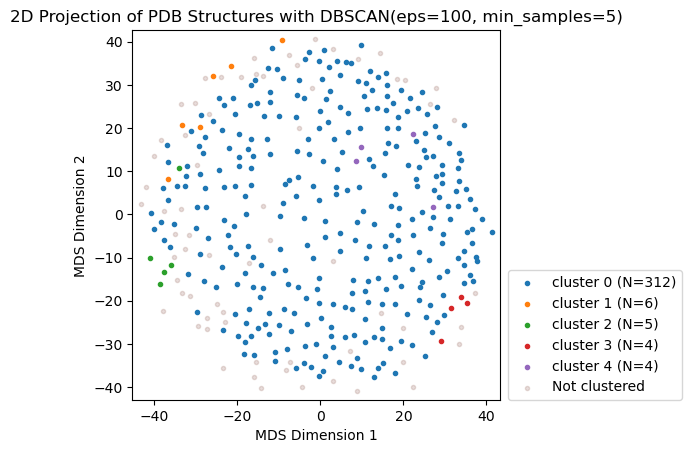

In [37]:
from sklearn.cluster import DBSCAN
eps =  100
min_samples = 5
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(rmsd)

plt.figure()
for c in set(clustering.labels_):
    if c == -1: 
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label="Not clustered", marker=".", alpha=0.2)
    else:
        n = sum(clustering.labels_ == c)
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label=f"cluster {c} (N={n})", marker=".")
plt.legend(loc = (1.02,0))
plt.xlim(min(coords[:, 0])-2, max(coords[:, 0])+2)
plt.ylim(min(coords[:, 1])-2, max(coords[:, 1])+2)

# plt.colorbar(label=label)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title(f'2D Projection of PDB Structures with DBSCAN(eps={eps}, min_samples={min_samples})')
plt.subplots_adjust(right=0.7)
plt.savefig(f"{top_pdb_dir}/rmsd_mds_dbscan_eps{eps}_min_samples{min_samples}.png", dpi=300)
plt.show()


In [34]:
import pandas as pd

df_scores = pd.read_csv(f"{pdb_dir}/{casp_id}_scores.csv")
top_pdbs = !ls {top_pdb_dir}/*.pdb
top_pdbs = [os.path.basename(pdb).replace(".pdb", "") for pdb in top_pdbs]
df_scores = df_scores[df_scores["pdb"].isin(top_pdbs)]
df_scores

,pdb,BRiQscore,FARFARscore
4,S_000005,202.124,45.444
9,S_000010,194.105,566.456
10,S_000011,395.094,-2.636
13,S_000014,140.512,-98.901
14,S_000015,139.386,15.661
...,...,...,...
988,S_000989,260.709,39.553
991,S_000992,194.764,272.522
992,S_000993,105.518,66.072
993,S_000994,215.176,61.044


In [35]:
df_scores["cluster"] = clustering.labels_
df_scores.to_csv(f"{top_pdb_dir}/{casp_id}_scores_clustered_eps{eps}.csv", index=False)
df_scores = pd.read_csv(f"{top_pdb_dir}/{casp_id}_scores_clustered_eps{eps}.csv")
df_scores.head(3)

,pdb,BRiQscore,FARFARscore,cluster
0,S_000005,202.124,45.444,0
1,S_000010,194.105,566.456,-1
2,S_000011,395.094,-2.636,0


In [36]:
pdb_list = []

print(" Sorted by BRiQscore")
print(df_scores.sort_values("BRiQscore").head(10))
pdb_list.extend(df_scores.sort_values("BRiQscore").head(5)["pdb"].values)
print(" Sorted by FARFARscore")
print(df_scores.sort_values("FARFARscore").head(10))
pdb_list.extend(df_scores.sort_values("FARFARscore").head(5)["pdb"].values)
print("**"*20)



 Sorted by BRiQscore
          pdb  BRiQscore  FARFARscore  cluster
124  S_000315   -60.5122      704.179        0
328  S_000805   -43.5652      697.785        0
358  S_000873   -32.4753      401.293        0
304  S_000742   -31.9931     -158.775        0
108  S_000271   -25.6739      202.033        0
242  S_000587   -21.0449      -13.459        0
188  S_000458   -20.0218      464.065        0
336  S_000822   -13.6757      -96.286        0
233  S_000554    -3.2050      124.623       -1
369  S_000918    18.6077      -58.357        0
 Sorted by FARFARscore
          pdb  BRiQscore  FARFARscore  cluster
88   S_000223   199.5360     -210.740        0
149  S_000378   125.5750     -207.032        0
283  S_000683    95.2744     -175.406       -1
224  S_000540   133.5710     -173.843        0
341  S_000829   159.4110     -162.959        0
91   S_000232   161.4290     -161.535        0
96   S_000241   121.3450     -160.925        0
304  S_000742   -31.9931     -158.775        0
296  S_000720   